In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

import deepinv as dinv
from deepinv.optim.optim_iterators import SMIteration
from deepinv.optim.prior import Zero
from deepinv.optim.data_fidelity import L2, AmplitudeLoss
from deepinv.physics.phase_retrieval import RandomPhaseRetrieval

/var/folders/g7/kcfjzxyn1klcs6f0xk8vby0w0000gn/T/ipykernel_49158/3932969885.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = torch.manual_seed(0) # Random seed for reproducibility
x = torch.randn((1, 1, 10, 10),dtype=torch.cfloat) # Define random 3x3 image

In [4]:
physics = RandomPhaseRetrieval(m=500,img_shape=(1,10,10))
print(physics(x).shape)

torch.Size([1, 500])


In [9]:
u = torch.randn((1, 1, 10, 10),dtype=torch.cfloat) # Define a random image
err = physics.B.adjointness_test(u)
err.abs()

tensor(7.2512e-06)

In [10]:
r = physics.A_adjoint(physics.A(x))
y = physics.B(r)
error = (physics.A_dagger(y) - r).flatten().mean().abs()
error

tensor(1.2897e-08)

# Compare the performance of GD with/without spectral methods 

In [3]:
# with m=40 can reconstruct at most times, with m=100 almost surely
img_shape = (1, 10, 10)
x = torch.randn((1,) + img_shape, dtype=torch.cfloat) # Define random 3x3 image
# physics = RandomPhaseRetrieval(m=500, img_shape=img_shape)
physics = RandomPhaseRetrieval(m=500,img_shape=(1,10,10))
y = physics(x)

loss_fn = AmplitudeLoss()

In [4]:
iterator = dinv.optim.optim_iterators.GDIteration()

loss_init: tensor([37.1775])
loss_final: tensor([1.1415])


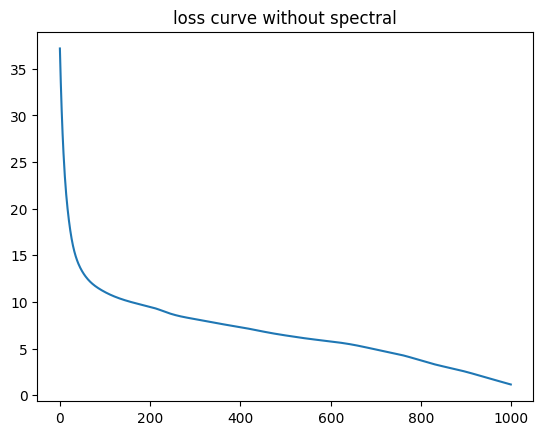

In [5]:
# without spectral
x_est = torch.ones_like(x)
# correlation between true measurements and initial guess
loss_fn(x_est, physics(x), physics)

loss_hist = []
for _ in range(1000):
    res = iterator({"est": (x_est,), "cost": 0},
        cur_data_fidelity=loss_fn,
        cur_prior=Zero(),
        cur_params={"stepsize": 0.05, "lambda": 1.0, "g_param":[]},
        y=y,
        physics=physics)
    x_est = res["est"][0]
    loss_hist.append(loss_fn(x_est, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.title('loss curve without spectral')
plt.show()

loss_init: tensor([69.6057])
loss_final: tensor([2.4750])


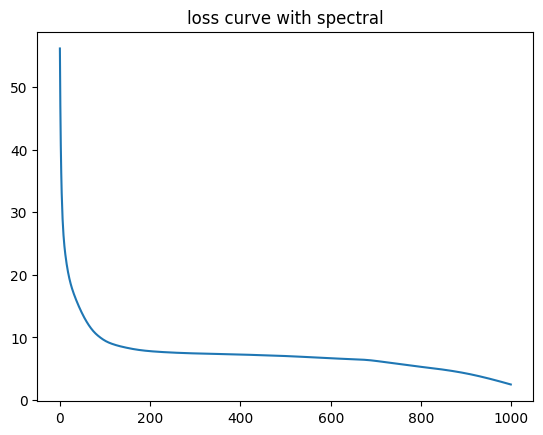

In [9]:
# with spectral
x_est = torch.ones_like(x)
x_est = x_est / torch.norm(x_est.flatten())

preprocessing = lambda x: torch.max(1 - 1/x, torch.tensor(-5.0))

spectral = SMIteration(lamb=1.0, preprocessing=preprocessing)

diff_hist = []

# spectral methods iteration
for _ in range(50):
    x_new = spectral(x_est,
                     Zero(),
                    {"stepsize": 0.05, "lambda": 1.0, "g_param":[]},
                    y,
                    physics)
    diff_hist.append(torch.norm(x_new - x_est))
    x_est = x_new

x_est = - x_est
# correlation between true measurements and spectral methods initialization
print("loss_init:",loss_fn(x_est.reshape(x.shape), physics(x), physics))

loss_hist = []
x_est = x_est.reshape(x.shape)
for _ in range(1000):
    res = iterator({"est": (x_est,), "cost": 0},
        cur_data_fidelity=loss_fn,
        cur_prior=Zero(),
        cur_params={"stepsize": 0.05, "lambda": 1.0, "g_param":[]},
        y=y,
        physics=physics)
    x_est = res["est"][0]
    loss_hist.append(loss_fn(x_est, y, physics))

print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.title('loss curve with spectral')
plt.show()

# Plot the correlation curve w.r.t oversampling ratio

In [3]:
RANGE_M = 150
REPEATS = 100
IMG_SHAPE = (1, 3, 3)

avg_cosines = []
raw_cosines = torch.zeros((RANGE_M, REPEATS))

loss_fn = AmplitudeLoss()
iterator = dinv.optim.optim_iterators.GDIteration()
params_algo = {"stepsize": 0.05, "lambda": 1.0}
optimalgo = dinv.optim.BaseOptim(iterator,
                    data_fidelity=loss_fn,
                    params_algo=params_algo,)

for m in tqdm(range(1,RANGE_M+1)):
    physics = RandomPhaseRetrieval(m=m, img_shape=IMG_SHAPE)
    cosines = []
    for i in range(REPEATS):
        x = torch.randn((1,) + IMG_SHAPE,dtype=torch.cfloat) # Define random 3x3 image
        xhat = optimalgo(physics(x), physics)
        cosine = (xhat.flatten().conj().T @ x.flatten())/(xhat.norm() * x.norm())
        if torch.isnan(cosine):
            cosines.append(0)
        else:
            cosines.append(cosine.abs())
        raw_cosines[m-1, i] = cosines[-1]
    avg_cosines.append(sum(cosines)/len(cosines))
oversampling_ratio = [i/np.prod(IMG_SHAPE) for i in range(1,RANGE_M+1)]

  0%|          | 0/150 [00:00<?, ?it/s]


AttributeError: 'RandomPhaseRetrieval' object has no attribute 'A_adjoint'

In [26]:
# save data
np.save('raw_cosines.npy', raw_cosines)
np.save('avg_cosines.npy', avg_cosines)

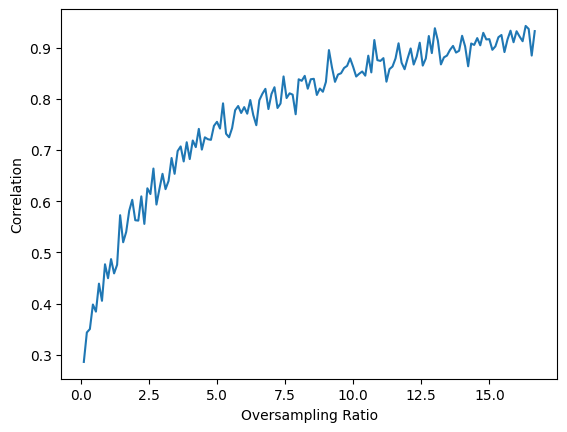

In [19]:
plt.plot(oversampling_ratio, avg_cosines)
plt.xlabel('Oversampling Ratio')
plt.ylabel('Correlation')
plt.show()